# Boxplot of top five up- and downregulated genes

In [3]:
suppressMessages({library(ggpubr)
                  library(tidyverse)
                  library(data.table)})

In [4]:
save_ggplots <- function(p, fn, w=7, h=7){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(p, filename=paste0(fn, ext), width=w, height=h)
    }
}


add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
        as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
        dplyr::ungroup() %>%
        mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}


## Select most significant DEGs, up- and downregulated

In [5]:
genes = fread('../../metrics_summary/_m/female_specific_DE_genes.txt') %>%
    filter(Type == 'gene') %>% add_symnum()
up_genes = genes %>% filter(t > 0) %>% mutate('Direction'='Upregulated') %>% head(5)
down_genes = genes %>% filter(t < 0) %>% mutate('Direction'='Downregulated') %>% head(5)
sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(sig_genes$Symbol[xx] == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}
sig_genes

Feature,gencodeID,Symbol,ensemblID,Chrom,logFC,t,adj.P.Val,Male_Pval,Male_FDR,Type,FDR,p.signif,Direction,New_ID
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<chr>
ENSG00000132429.9,ENSG00000132429.9,POPDC3,ENSG00000132429,chr6,0.2587666,5.178715,0.0003787083,0.19431837,0.2588773,gene,0.00038,***,Upregulated,POPDC3
ENSG00000165733.7,ENSG00000165733.7,BMS1,ENSG00000165733,chr10,0.1509181,4.986552,0.0005346726,0.05973572,0.1218271,gene,0.00053,***,Upregulated,BMS1
ENSG00000204147.9,ENSG00000204147.9,ASAH2B,ENSG00000204147,chr10,0.2140580,4.875357,0.0006999462,0.23947936,0.3011408,gene,0.00070,***,Upregulated,ASAH2B
ENSG00000081307.12,ENSG00000081307.12,UBA5,ENSG00000081307,chr3,0.1449995,4.865390,0.0006999462,0.06478184,0.1267362,gene,0.00070,***,Upregulated,UBA5
ENSG00000147419.17,ENSG00000147419.17,CCDC25,ENSG00000147419,chr8,0.1698827,4.853583,0.0006999462,0.12466875,0.1900657,gene,0.00070,***,Upregulated,CCDC25
ENSG00000268049.1,ENSG00000268049.1,,ENSG00000268049,chr19,-0.3193858,-4.775427,0.0007897721,0.23364519,0.2960191,gene,0.00079,***,Downregulated,ENSG00000268049
ENSG00000184916.8,ENSG00000184916.8,JAG2,ENSG00000184916,chr14,-0.2965514,-4.552618,0.0014099360,0.15810008,0.2226871,gene,0.00141,**,Downregulated,JAG2
ENSG00000166159.10,ENSG00000166159.10,LRTM2,ENSG00000166159,chr12,-0.2715682,-4.545537,0.0014420060,0.06852146,0.1312515,gene,0.00144,**,Downregulated,LRTM2
ENSG00000104880.17,ENSG00000104880.17,ARHGEF18,ENSG00000104880,chr19,-0.1595113,-4.492019,0.0016614819,0.15213171,0.2176239,gene,0.00166,**,Downregulated,ARHGEF18


## Load phenotypes

In [6]:
pheno_file = paste0('/ceph/users/jbenja13/projects/sex_sz_ria/',
                    'input/commonMind/phenotypes/combine_files/',
                    '_m/CMC_phenotypes_all.csv')
pheno = fread(pheno_file) %>% 
    filter(Sex %in% c("XX", "XY"), 
           Dx %in% c("Control", "SCZ")) %>%
    mutate_if(is.character, as.factor) %>%
    select(c(Individual_ID, "RNAseq:Sample_RNA_ID", Dx, Sex))
colnames(pheno)[2] <- "SampleID"
levels(pheno$Sex) <- c("Female", "Male")
levels(pheno$Dx) <- c("CTL", "SZ")
pheno %>% head(2)

Individual_ID,SampleID,Dx,Sex
<fct>,<fct>,<fct>,<fct>
CMC_HBCC_003,CMC_HBCC_RNA_PFC_3158,CTL,Male
CMC_HBCC_005,CMC_HBCC_RNA_PFC_3152,CTL,Male


## Load residualized expression

In [7]:
res_file = '../../../../../interaction_sex_sz/cmc_dlpfc/_m/genes/residualized_expression.tsv'
resdf0 = fread(res_file) %>% 
    filter(V1 %in% sig_genes$gencodeID) %>% 
    column_to_rownames(var="V1") %>% t %>% 
    as.data.frame %>% rownames_to_column() %>% 
    rename(SampleID=rowname) %>% 
    mutate_at("SampleID", as.factor)
resdf0[1:2, 1:5]

Warning message in fread(res_file):
"Detected 858 column names but the data has 859 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,SampleID,ENSG00000081307.12,ENSG00000104880.17,ENSG00000132429.9,ENSG00000147419.17
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,MSSM_RNA_PFC_1,0.1197940,-0.09712872,0.003977056,-0.6553392
2,MSSM_RNA_PFC_2,-0.7099187,0.06995517,0.930716431,-0.7528546


### Merge and melt dataframe

In [8]:
df <- inner_join(pheno, resdf0, by="SampleID") %>%
    select(c('SampleID', 'Sex', 'Dx', starts_with('ENSG'))) %>% 
    pivot_longer(-c(SampleID, Sex, Dx), 
                 names_to='gencodeID', values_to="Res") %>% 
    inner_join(sig_genes, by='gencodeID') %>% 
    mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)
df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
df$Dx <- fct_drop(df$Dx)
dim(df)
df[1:2, 1:10]

[1] 8580   19

SampleID,Sex,Dx,gencodeID,Res,Feature,Symbol,ensemblID,Chrom,logFC
<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>,<fct>,<chr>,<chr>,<dbl>
CMC_HBCC_RNA_PFC_3158,Male,CTL,ENSG00000081307.12,0.08470579,ENSG00000081307.12,UBA5,ENSG00000081307,chr3,0.1449995
CMC_HBCC_RNA_PFC_3158,Male,CTL,ENSG00000104880.17,0.79014892,ENSG00000104880.17,ARHGEF18,ENSG00000104880,chr19,-0.1595113


### Initial ggplot with ggpubr

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


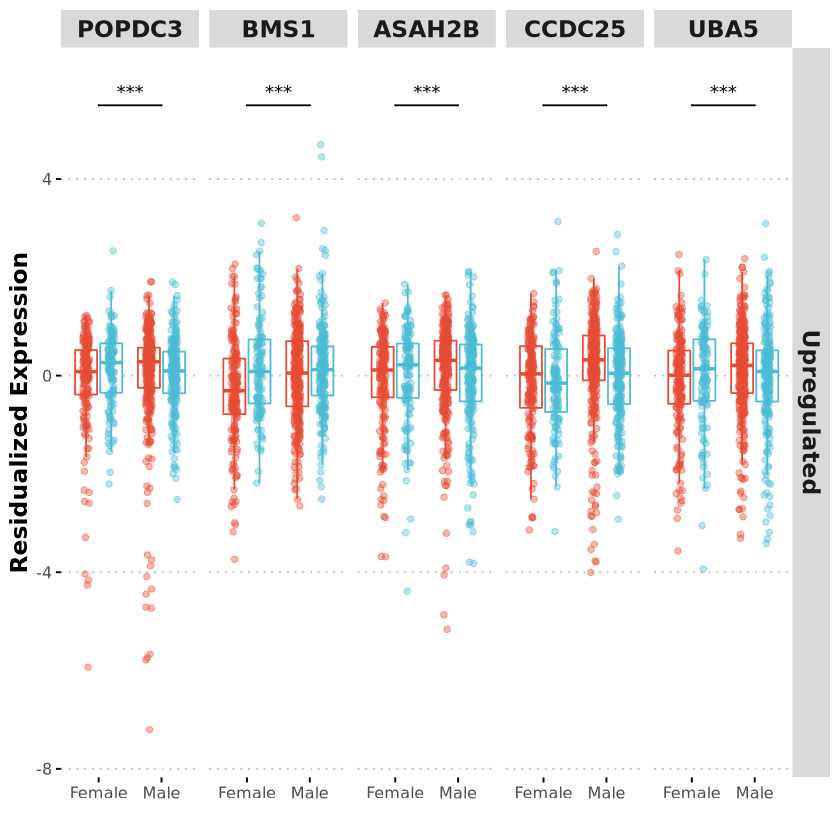

In [9]:
tmp = sig_genes %>% 
    mutate(group1='Female', group2='Male', y_pos=5.5) %>% 
    filter(Direction == 'Upregulated') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction=="Upregulated") %>%
        ggboxplot(x="Sex", y="Res", facet.by=c("Direction", "New_ID"), 
                  add='jitter', color="Dx", xlab='', palette="npg", 
                  panel.labs.font=list(face='bold', size = 14), 
                  ylab='Residualized Expression', ylim=c(-7.5, 6),
                  add.params=list(alpha=0.4), legend="", 
                  ggtheme=theme_pubclean(), outlier.shape=NA) +
         geom_signif(data=tmp, tip_length = 0,
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=14, face="bold") + font("legend.title", size=16, face="bold") + 
         font("legend.text", size=16)
         
bxp_up

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


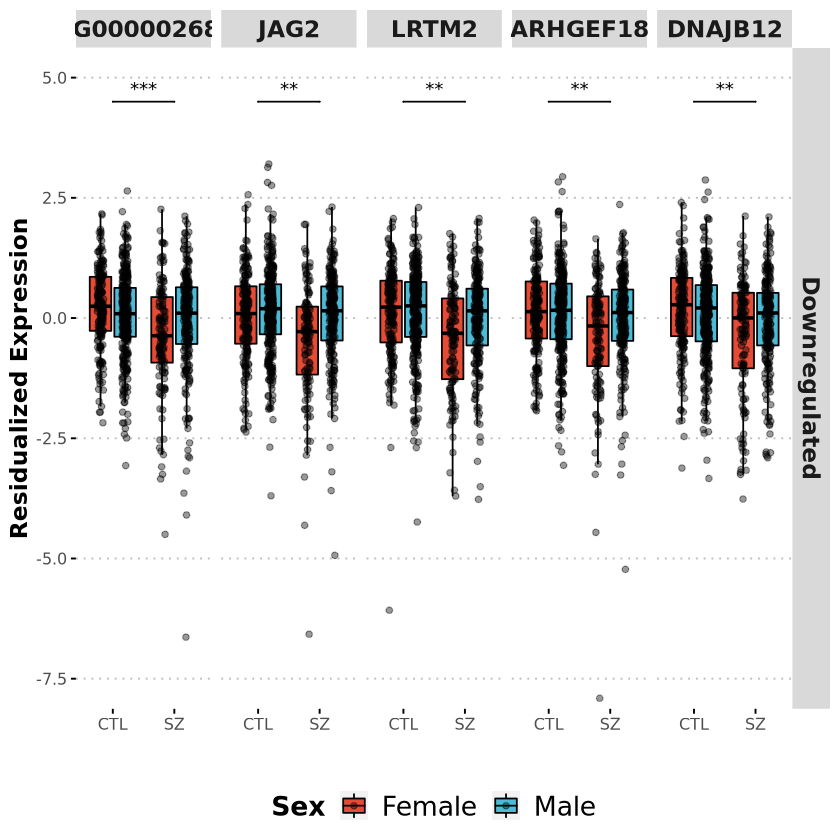

In [17]:
tmp = sig_genes %>% 
    mutate(group1='Female', group2='Male', y_pos=4.5) %>% 
    filter(Direction == 'Downregulated') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=="Downregulated") %>%
        ggboxplot(x="Sex", y="Res", facet.by=c("Direction", "New_ID"), 
                  add='jitter', color="Dx", xlab='', palette="npg", 
                  panel.labs.font=list(face='bold', size = 14), 
                  ylab='Residualized Expression', ylim=c(-7.5, 5),
                  add.params=list(alpha=0.4), legend="bottom", 
                  ggtheme=theme_pubclean(), outlier.shape=NA) +
         geom_signif(data=tmp, tip_length = 0,
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=14, face="bold") + font("legend.title", size=16, face="bold") + 
         font("legend.text", size=16)
         
bxp_down

### Annotate figure

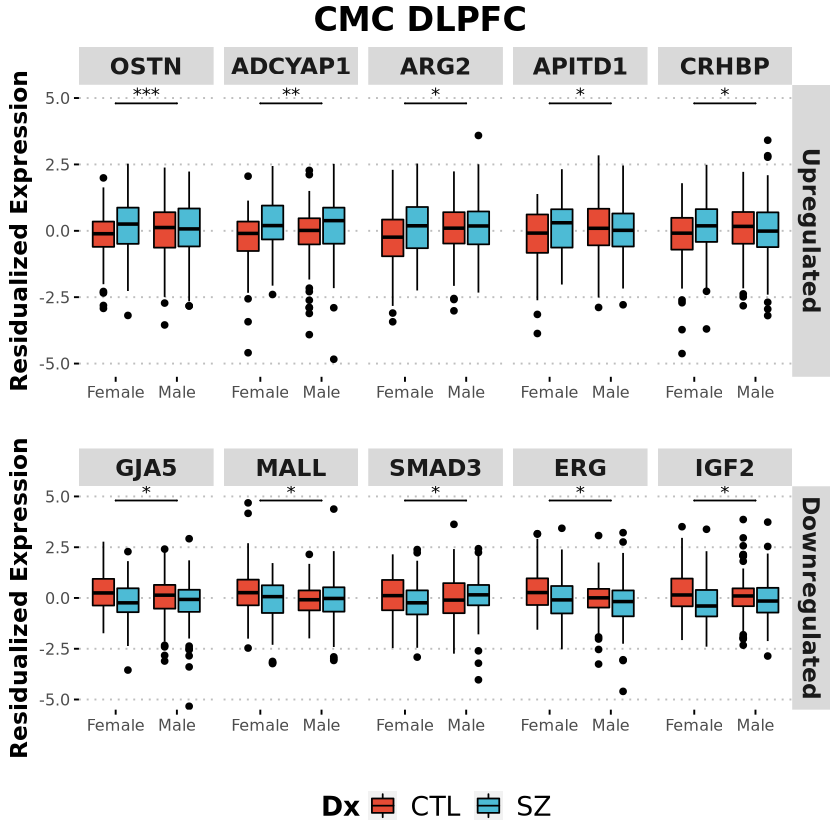

In [58]:
figure <- ggarrange(bxp_up, bxp_down, ncol = 1, nrow = 2)
figure <- annotate_figure(figure, top=text_grob("CMC DLPFC", size=20, face='bold'))
figure

In [61]:
save_ggplots(figure, 'femaleSpecific_SZ', 12, 10)

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()